<center> <h1> CmdStanPy goes to the Women's World Cup! </h1> </center>

<figure>
  <center><img src="wwc_2019.jpeg" width = "700"/></center>
</figure>
<center> <h2>#WeStan</h2></center>




<h2> Table of Contents:<a name="TOC"></a></h2>

- [0. On implementing a Bayesian Workflow Using CmdStanPy](#Intro)
- [1. Importing Packages + Data](#IDA)
- [2. Stan Input](#StanInput)
- [3. Stan Model for the WWC 2019](#StanModel)
- [4. Model Interpretation](#Interpret)
- [5. Visualizations!](#Plots)
- [6.Predictions!](#Pred)
- [7.Make your own tournament!](#Exercises)

<h2> 0. On Implementing a Bayesian Workflow using CmdStanPy<a name="Intro"></a> </h2>

[CmdStanPy](https://github.com/stan-dev/cmdstanpy) is a lightweight CLI (Command Line Interface) for Stan that allows Pythonistas to harness the full power of Stan as well by incorporating Stan's [impressive model suite](https://mc-stan.org/docs/2_19/stan-users-guide/regression-models.html) very easily and providing outputs as pandas dataframes for downstream analysis. <br>

We're going to look at the Women's World Cup 2019 data upto the semi-finals and get CmdStanPy model to: <br>
1. "Successfully" fit a model for all the matches up to the semi-finals <br>
2. Predict the winner of the semi-finals using the same <br>
3. And if time permits, create our own tournament lineups and see how different teams fare against each other! <br>

The data we use has been obtained from the [538](https://projects.fivethirtyeight.com/2019-womens-world-cup-predictions/). We use the team scores up until the semi's as well as the "soccer power index" (spi) prior to the tournament. The spi is an indicator of team ability going into World Cup 2019 and in the Bayesian sense, gives us a prior to work with. <br>

The model we use is inspired by Andrew Gelman's [blog post](https://statmodeling.stat.columbia.edu/2014/07/13/stan-analyzes-world-cup-data/) where he uses RStan to fit the FIFA Men's World Cup 2014 games. <br>

The main steps in this workflow are:
1. Specifying a [stan model](#StanModel)<br>
2. Massaging the data (yay, Pandas!) into the right form to input it to Stan <br>
3. Call the model using CmdStanPy <br>
4. Simulating all the matches until the semis using the model <br>
4. Evaluating the fit of the model to the data <br>
5. Generating new data, i.e., the semi-final scores using the model <br>
6. Comparing the generated score differential distributions of the semi's to the actual differentials <br>
7. Guessing the Final winner! <br>
8. Have fun generating fake world cup data! <br>
9. Prepare to build a better model for 2023 :) <br>


<h2> 1. Importing the Packages and Data!<a name="IDA"></a> </h2>

In [1]:
import cmdstanpy
import pandas as pd
from cmdstanpy import Model, StanFit
import ujson as json

We have two data files; The first one gives us information upto the quarterfinals:

In [2]:
matches = pd.read_csv('../data/womens_world_cup_2019.csv')
matches.head()

,date,match_list,team_1,team_2,score_1,score_2
0,2019-06-07,France vs South Korea,France,South Korea,4.0,0.0
1,2019-06-08,Germany vs China,Germany,China,1.0,0.0
2,2019-06-08,Spain vs South Africa,Spain,South Africa,3.0,1.0
3,2019-06-08,Norway vs Nigeria,Norway,Nigeria,3.0,0.0
4,2019-06-09,Australia vs Italy,Australia,Italy,1.0,2.0


The second one is a list of the countries that participated in the decreasing order of "ability" prior to the tournament. This would be our **prior** here.<br>

We use the *"soccer power index"*, abbreviated here as "spi", as determined at [538 by Nate Silver](https://fivethirtyeight.com/methodology/how-our-club-soccer-predictions-work/). In the stan model, these feature as "prior_score" in the input and as "ability" in the model.

In [3]:
countries = pd.read_csv('../data/country_prior.csv')
countries.head()

,country,spi
0,USA,97.20623
1,France,95.31747
2,Germany,94.17161
3,Australia,93.13200
4,Netherlands,92.70844


We're going to rescale the prior here such that they have a mean of 0! (Ahem, floating points notwithstanding.)

In [4]:
import numpy as np
mean = np.mean(countries['spi'])
std = np.std(countries['spi'])

#Rescaling the prior!
countries['prior_score'] = [(x - mean)/std for x in countries['spi']]

In [5]:
country_mapping = countries.country.to_dict()
country_mapping = {k:v+1 for v,k in country_mapping.items()}

<h2> 2. Inputting the Data to CmdStanPy <a name="StanInput"></a>  </h2>

The input data for the model needs to be in a dictionary format with the following keys: <br>

1. I: The number of teams <br>
2. N: The number of matches played <br>
3. team_1: A column of the "first" team <br>
4. team_2: A column of the "second" team <br>
5. prior_score: The countries' prior scores (i.e., spi's before the tournament) sorted in the descending order <br>

In [41]:
N = len(matches)
I = len(countries)
mydict = dict({'I': I,
               'N': N,
                'team_1': matches['team_1'].values,
               'team_2': matches['team_2'].values,
               'score_1': matches['score_1'].values,
               'score_2': matches['score_2'].values,
              'prior_score': countries['prior_score'].values})

We're now going to refer to the teams by a number that represents their pre-tournament ranking. To do that we first define a dictionary where the keys are the country names and the values are the team ranking.

In [42]:
#Replace team names by their rankings;
mydict['team_1'] = [ country_mapping.get(x) for x in mydict['team_1']]
mydict['team_2'] = [ country_mapping.get(x) for x in mydict['team_2']]

Our data is now prepped. We are ready to model it!

<h2> 3. Stan Model for the Women's World Cup <a name="StanModel"></a> </h2>

This story is a long one and it can be as involved as you'd like it to be. The model we use here is based on a theory known as ["Item Response Theory"](https://mc-stan.org/docs/2_19/stan-users-guide/item-response-models-section.html) which says that the difference in the goals scored in a match should depend in some way on the difference in the "ability" between the teams. It's a simple but powerful idea that has an [applications](https://mc-stan.org/events/stancon2017-notebooks/stancon2017-groves-irt.html) in trying to predict the outcome of a task that inherently depends on how hard the task is and how "competent" the agent carrying out is. <br>

If you want to take a quick peek into the model, it's right [here](https://github.com/nyc-pyladies/2019-cmdstanpy-bayesian-workshop/blob/master/models/worldcup_pyladies.stan)! You can skip the following description and move on to the next cell if you would like.

*But if you'd like to know more, read on!* :) 

**A typical Stan program is divided into the following blocks:**

**1. Data**: *Where you declare all the information that must be supplied for the program to run* <br>
In our specific case we have: <br>
(a) Number of teams and number of matches <br>
(b) the goals scored in 48 matches (data) <br>
(c) the ability of each team prior to the tournament (prior) <br>
(We have already prepped the data in the previous section!)

**2. Transformed Data**: *These are mathematical operations that are performed once when the Stan program is called* <br>
At the end of the day, we care about predicting the "score differentials", i.e. the difference in goals scored between Team 1 and Team 2. <br>
The data is thus transformed into: <br>
$$y = \hbox{score}_1 - \hbox{score}_2$$ <br>
(Where $y > 0$, Team 1 won!)

**3. Parameters**: *These are the unknown quantities that are estimated when the Stan program is run.*<br>
In the item response model, we essentially have two parameters: $\alpha$, which can be thought of as weights per-team and a common intercept, $\beta$. Both parameters would be drawn from a set of normal distributions (i.e., priors on the parameters) along with the noise terms associated with the transformed abilities, $\sigma_a$ and score differentials, $\sigma_y$.

**4. Transformed Parameters**: *Computations that depend on parameters as well as data, thus must be computed in each step when Stan runs.*<br>
The "abilities" (i.e., soccer power index) we have disussed so far, are an attempt at quantifying our prior knowledge of the team's abilities. These must be updated as more games get played. Our model must be able to update these abilities based on what we can infer from the performance of the team. Our new "abilities" for each team 'i' would be: <br>
$$a_i = \beta \times \hbox{prior_score} + \sigma_a \times \alpha_i $$
We would like to infer the distributions of $\beta$ and $\alpha$ - we assume normal prior on both for starters.

**5. Model**: *This is the part of the Stan program where the objective function is computed.* <br>
The model we have for the score differentials now is: <br>
$$y_i \sim t(\hbox{df}, a_i[\hbox{team1}] - a_i[\hbox{team2}], \sigma_y) $$
where t is the ["student t distribution"](https://en.wikipedia.org/wiki/Student%27s_t-distribution).

**6. Generated quantities**: *These are computed at the end of each iteration and saved.* <br>
In the following example, we will essentially be simulating the entire tournament (upto the semis) using the model described above. The generated quantities would thus be the distributions of the score differentials 

(Paraphrased from Andrew Gelman's upcoming Bayes Workflow book)^^

In [8]:
stan_wc = Model(stan_file='../models/worldcup_pyladies.stan')
stan_wc.compile()
stan_wc

INFO:cmdstanpy:stan to c++ (../models/worldcup_pyladies.hpp)
INFO:cmdstanpy:compiling c++
INFO:cmdstanpy:compiled model file: /Users/nitya/Work/2019-cmdstanpy-bayesian-workshop/models/worldcup_pyladies


Model(name=worldcup_pyladies,  stan_file="../models/worldcup_pyladies.stan", exe_file="/Users/nitya/Work/2019-cmdstanpy-bayesian-workshop/models/worldcup_pyladies")

We can now fit the model to the data. 


From the Bayes Workflow book..:

Stan’s fitting algorithms are iterative. The algorithm starts with some initial values for all the parameters (these can be user-specified and fed into the call to Stan, or else Stan will simulate them from a default distribution; (see Chapter “MCMC Sampling”, section “Initialization” of the Stan Reference Manual) and then, at each iteration, the parameter values are updated. After enough iterations, the parameter values converge to an estimate of the optimum (if Stan is being set to optimization) or to an estimate of the center of the distribution (if Stan is being set to distributional approximation) or the iterations will wander through the posterior distribution (if Stan is being set to sample).

In the HMC and NUTS algorithms (and recall that NUTS is Stan’s default), each iteration includes some number of steps. In each step, Stan computes the gradient of the objective function, which is used in the “leapfrog algoritm” to determine the direction in which the algorithm moves (see Section 12.4 of Bayesian Data Analysis and the “MCMC Sampling” chapter of the Stan Reference Manual). An iteration might have tens or hundreds of steps. The information from each step is not saved by Stan; what is returned is the value of the parameters at the end of each iteration.

In [9]:
worldcup_fit = stan_wc.sample(data=mydict, chains=4)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [10]:
worldcup_fit.diagnose()


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmp6aslc5bk/stan-worldcup_pyladies-draws-1-c51fzztc.csv, /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmp6aslc5bk/stan-worldcup_pyladies-draws-2-amepmmbs.csv, /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmp6aslc5bk/stan-worldcup_pyladies-draws-3-zewmdc35.csv, /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmp6aslc5bk/stan-worldcup_pyladies-draws-4-evu3fedy.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

The Stanfit "summary" method gives us a peek into the distributions of all the parameters. CmdStanPy outputs the same as a pandas dataframe for downstream analysis:

In [11]:
df = worldcup_fit.summary().round(decimals = 2)
df

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-51.95,0.33,7.07,-64.29,-51.50,-41.23,462.15,396.14,1.02
beta,0.92,0.01,0.26,0.49,0.92,1.34,1424.34,1220.87,1.00
alpha[1],0.98,0.01,0.68,-0.15,0.98,2.07,2974.31,2549.43,1.00
alpha[2],0.34,0.01,0.63,-0.70,0.35,1.38,3951.29,3386.84,1.00
alpha[3],0.41,0.01,0.64,-0.66,0.42,1.44,3626.75,3108.66,1.00
alpha[4],-0.20,0.01,0.64,-1.25,-0.21,0.88,4182.62,3585.12,1.00
alpha[5],0.47,0.01,0.64,-0.59,0.47,1.50,3579.77,3068.39,1.00
alpha[6],0.58,0.01,0.68,-0.56,0.60,1.64,3112.05,2667.48,1.00
alpha[7],-0.72,0.01,0.74,-2.01,-0.69,0.43,3000.63,2571.99,1.00



What you see above above is a dataframe of the summary of the "stanfit" object:

From the Stan [documentation](https://mc-stan.org/rstan/reference/stanfit-class.html):<br>
An object of class stanfit contains the output derived from fitting a Stan model as returned by the top-level function stan or the lower-level methods sampling and vb (which are defined on class stanmodel). Many methods (e.g., print, plot, summary) are provided for summarizing results and various access methods also allow the underlying data (e.g., simulations, diagnostics) contained in the object to be retrieved.

The summary method returns a named list with elements summary and c_summary, which contain summaries for for all chains merged and individual chains, respectively. Included in the summaries are quantiles, means, standard deviations (sd), effective sample sizes (n_eff), and split Rhats (the potential scale reduction derived from all chains after splitting each chain in half and treating the halves as chains). For the summary of all chains merged, Monte Carlo standard errors (se_mean) are also reported.

<h2> 4. Interpreting the Model Fit <a name="Interpret"></a> </h2>

In [12]:
dft = df.transpose()
ability_filter = [col for col in dft if col.startswith('ability')]
yrep_filter = [col for col in dft if col.startswith('y_rep')]

In [13]:
#Abilities
abilities = dft[ability_filter]
abilities

name,ability[1],ability[2],ability[3],ability[4],ability[5],ability[6],ability[7],ability[8],ability[9],ability[10],...,ability[15],ability[16],ability[17],ability[18],ability[19],ability[20],ability[21],ability[22],ability[23],ability[24]
Mean,2.01,1.28,1.30,0.66,1.27,1.41,0.18,0.64,0.60,1.02,...,-1.08,0.55,-0.61,-0.62,-1.38,-2.11,-0.79,-2.56,-1.11,-0.89
MCSE,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.02,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.01,0.03
StdDev,0.63,0.54,0.56,0.58,0.54,0.61,0.61,0.56,0.60,0.55,...,0.81,0.60,0.62,0.57,0.65,0.77,0.77,0.78,0.65,0.92
5%,1.01,0.39,0.39,-0.33,0.39,0.44,-0.84,-0.29,-0.40,0.14,...,-2.45,-0.40,-1.65,-1.53,-2.48,-3.44,-1.98,-3.88,-2.15,-2.39
50%,1.99,1.27,1.29,0.67,1.25,1.38,0.19,0.65,0.61,1.01,...,-1.07,0.54,-0.58,-0.64,-1.35,-2.10,-0.81,-2.53,-1.11,-0.91
95%,3.08,2.18,2.23,1.59,2.18,2.44,1.14,1.56,1.56,1.94,...,0.23,1.54,0.36,0.33,-0.37,-0.88,0.51,-1.33,-0.02,0.61
N_Eff,2039.32,4108.69,4049.54,3220.74,3497.23,1827.14,3621.61,3363.77,3750.85,2477.15,...,1422.26,2936.41,3316.82,4240.59,3441.83,1255.87,1571.46,2099.05,3044.07,964.29
N_Eff/s,1747.99,3521.76,3471.06,2760.65,2997.64,1566.13,3104.25,2883.25,3215.03,2123.29,...,1219.09,2516.94,2843.00,3634.82,2950.16,1076.47,1346.97,1799.20,2609.22,826.54
R_hat,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.01,1.00,1.00,1.00,1.00,1.01,1.01,1.00,1.00,1.01


In [14]:
#Team Differentials
td = dft[yrep_filter]
td

name,y_rep[1],y_rep[2],y_rep[3],y_rep[4],y_rep[5],y_rep[6],y_rep[7],y_rep[8],y_rep[9],y_rep[10],...,y_rep[39],y_rep[40],y_rep[41],y_rep[42],y_rep[43],y_rep[44],y_rep[45],y_rep[46],y_rep[47],y_rep[48]
Mean,2.31,1.36,1.84,0.89,0.13,2.73,2.21,-1.05,1.29,-1.67,...,2.04,0.67,-1.57,0.37,0.59,1.09,-1.09,-0.73,-0.73,0.28
MCSE,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.02,0.03,...,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.02
StdDev,1.73,1.59,1.66,1.61,1.62,1.67,1.67,1.76,1.59,1.71,...,1.63,1.60,1.62,1.60,1.67,1.64,1.68,1.56,1.63,1.58
5%,-0.53,-1.21,-0.90,-1.66,-2.36,0.09,-0.42,-3.90,-1.22,-4.30,...,-0.70,-2.00,-4.14,-2.21,-2.11,-1.58,-3.67,-3.15,-3.41,-2.29
50%,2.39,1.37,1.84,0.91,0.07,2.75,2.19,-0.99,1.27,-1.69,...,2.08,0.66,-1.57,0.41,0.64,1.10,-1.14,-0.78,-0.72,0.27
95%,5.00,3.94,4.42,3.45,2.70,5.39,4.86,1.66,3.76,1.03,...,4.62,3.22,1.15,2.90,3.20,3.65,1.65,1.88,1.86,2.79
N_Eff,2741.47,3682.92,4271.85,4055.77,3564.19,3654.24,4314.63,2692.37,4365.23,3274.01,...,3820.36,3892.88,4182.20,3694.13,3798.82,4111.75,3185.10,3673.35,4027.94,4186.07
N_Eff/s,2349.85,3156.80,3661.60,3476.39,3055.03,3132.23,3698.27,2307.76,3741.65,2806.31,...,3274.61,3336.77,3584.76,3166.41,3256.15,3524.37,2730.10,3148.60,3452.54,3588.08
R_hat,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [15]:
td

name,y_rep[1],y_rep[2],y_rep[3],y_rep[4],y_rep[5],y_rep[6],y_rep[7],y_rep[8],y_rep[9],y_rep[10],...,y_rep[39],y_rep[40],y_rep[41],y_rep[42],y_rep[43],y_rep[44],y_rep[45],y_rep[46],y_rep[47],y_rep[48]
Mean,2.31,1.36,1.84,0.89,0.13,2.73,2.21,-1.05,1.29,-1.67,...,2.04,0.67,-1.57,0.37,0.59,1.09,-1.09,-0.73,-0.73,0.28
MCSE,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.02,0.03,...,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.02
StdDev,1.73,1.59,1.66,1.61,1.62,1.67,1.67,1.76,1.59,1.71,...,1.63,1.60,1.62,1.60,1.67,1.64,1.68,1.56,1.63,1.58
5%,-0.53,-1.21,-0.90,-1.66,-2.36,0.09,-0.42,-3.90,-1.22,-4.30,...,-0.70,-2.00,-4.14,-2.21,-2.11,-1.58,-3.67,-3.15,-3.41,-2.29
50%,2.39,1.37,1.84,0.91,0.07,2.75,2.19,-0.99,1.27,-1.69,...,2.08,0.66,-1.57,0.41,0.64,1.10,-1.14,-0.78,-0.72,0.27
95%,5.00,3.94,4.42,3.45,2.70,5.39,4.86,1.66,3.76,1.03,...,4.62,3.22,1.15,2.90,3.20,3.65,1.65,1.88,1.86,2.79
N_Eff,2741.47,3682.92,4271.85,4055.77,3564.19,3654.24,4314.63,2692.37,4365.23,3274.01,...,3820.36,3892.88,4182.20,3694.13,3798.82,4111.75,3185.10,3673.35,4027.94,4186.07
N_Eff/s,2349.85,3156.80,3661.60,3476.39,3055.03,3132.23,3698.27,2307.76,3741.65,2806.31,...,3274.61,3336.77,3584.76,3166.41,3256.15,3524.37,2730.10,3148.60,3452.54,3588.08
R_hat,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


<h2> 5. Let's Make Some Plots!<a name="Plots"></a> </h2>

In [16]:
import matplotlib.pyplot as plt
df_teamdifferentials = pd.DataFrame({'midway': td.loc['50%'].values,
                                       'names':matches['match_list']})
df_teamdifferentials.loc[:, 'left'] = td.loc['5%'].values
df_teamdifferentials.loc[:, 'right'] = td.loc['95%'].values

In [17]:
actual_differentials = np.array([matches['score_1'][i]-matches['score_2'][i]  for i in range(len(matches))])

/Users/nitya/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


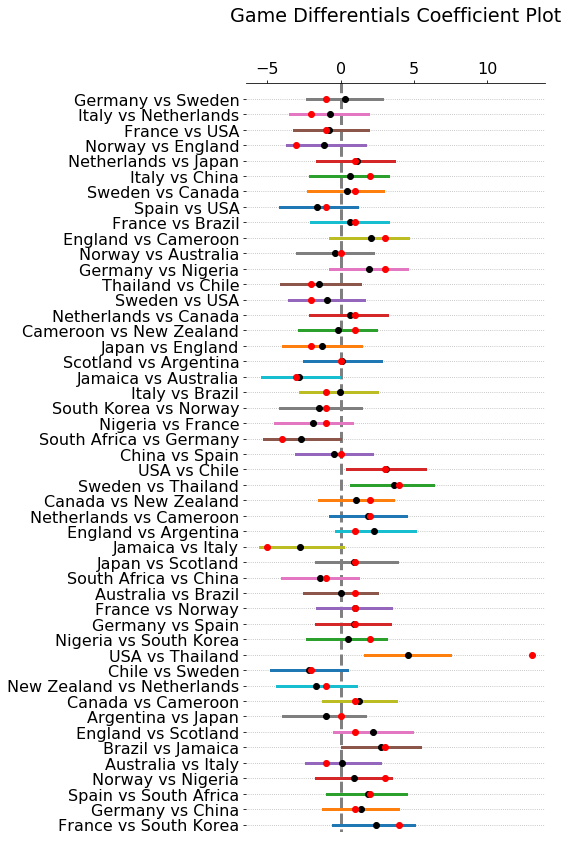

In [18]:
from coefplot import coefficient_plot

coefficient_plot(df_teamdifferentials['midway'], df_teamdifferentials['left'], 
                 df_teamdifferentials['right'], actual_differentials, 
                 names=df_teamdifferentials['names'],
                 title='Game Differentials Coefficient Plot', 
                fig_size = (8,12))
plt.tight_layout()

In [19]:
df_abilities = pd.DataFrame({'midway': abilities.loc['50%'].values,
                                       'names': countries['country']})
df_abilities.loc[:, 'left'] = abilities.loc['5%'].values
df_abilities.loc[:, 'right'] = abilities.loc['95%'].values

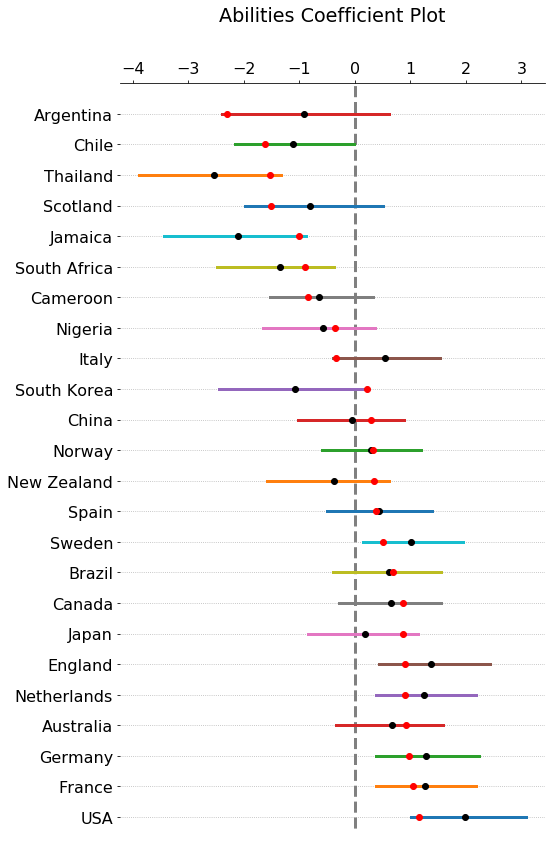

In [20]:
coefficient_plot(df_abilities['midway'], df_abilities['left'], 
                 df_abilities['right'], countries['prior_score'], 
                 names=df_abilities['names'],
                 title='Abilities Coefficient Plot',
                fig_size = (8,12))
plt.tight_layout()

<h2> 6. Let's Make Some Predictions! <a name="Pred"></a> </h2>

Here's what actually happened at the Semi-finals.

**The Semi-finals:** <br>
**1. England vs USA : 1-2**<br>
**2. Netherlands vs Sweden: 1-0**<br>

We are going to generate these matches using Stan and get the score-differentials. This is similar to what we did in the previous section: instead of "replaying" all the matches based on the tournament simulations, we are going to "play" the semi-finals and get the score differentials. Since we're a good month ahead of the events, we have the actual data for these matches and we get to assess how good our predictions are!


In [43]:
semis_dict = dict({'team_1': ['England', 'Netherlands'],
                 'team_2': ['USA', 'Sweden'],
                   'match_list': ['England vs USA', 'Netherlands vs Sweden'],
                  'actual_score_differential': [-1, 1]})

semis_dict['team_1'] = [ country_mapping.get(x) for x in semis_dict['team_1']]
semis_dict['team_2'] = [ country_mapping.get(x) for x in semis_dict['team_2']]
semis_dict

{'team_1': [6, 5],
 'team_2': [1, 10],
 'match_list': ['England vs USA', 'Netherlands vs Sweden'],
 'actual_score_differential': [-1, 1]}

In [44]:
mydict.update({'team_1_semis':[6, 5],
                'team_2_semis':[1, 10]})

In [45]:
mydict

{'I': 24,
 'N': 48,
 'team_1': [2,
  3,
  11,
  13,
  4,
  9,
  6,
  24,
  8,
  12,
  23,
  1,
  17,
  3,
  2,
  4,
  19,
  7,
  20,
  6,
  5,
  8,
  10,
  1,
  14,
  19,
  17,
  15,
  16,
  20,
  21,
  7,
  18,
  5,
  10,
  22,
  3,
  13,
  6,
  2,
  11,
  10,
  16,
  5,
  13,
  2,
  16,
  3],
 'team_2': [15,
  14,
  19,
  17,
  16,
  20,
  21,
  7,
  18,
  5,
  10,
  22,
  15,
  11,
  13,
  9,
  14,
  21,
  16,
  24,
  18,
  12,
  22,
  23,
  11,
  3,
  2,
  13,
  9,
  4,
  24,
  6,
  12,
  8,
  1,
  23,
  17,
  4,
  18,
  9,
  1,
  8,
  14,
  7,
  6,
  1,
  5,
  10],
 'score_1': array([ 4.,  1.,  3.,  3.,  1.,  3.,  2.,  0.,  1.,  0.,  0., 13.,  2.,
         1.,  2.,  3.,  0.,  2.,  0.,  1.,  3.,  2.,  5.,  3.,  0.,  0.,
         0.,  1.,  0.,  1.,  3.,  0.,  2.,  2.,  0.,  0.,  3.,  1.,  3.,
         2.,  1.,  1.,  2.,  2.,  0.,  1.,  0.,  1.]),
 'score_2': array([0., 0., 1., 0., 2., 0., 1., 0., 0., 1., 2., 0., 0., 0., 1., 2., 1.,
        1., 5., 0., 1., 0., 1., 0., 0., 4., 1., 2.,

In [34]:
stan_wc_semis = Model(stan_file='../models/worldcup_semis.stan')
stan_wc_semis.compile()
stan_wc_semis

INFO:cmdstanpy:stan to c++ (../models/worldcup_semis.hpp)
INFO:cmdstanpy:compiling c++
INFO:cmdstanpy:compiled model file: /Users/nitya/Work/2019-cmdstanpy-bayesian-workshop/models/worldcup_semis


Model(name=worldcup_semis,  stan_file="../models/worldcup_semis.stan", exe_file="/Users/nitya/Work/2019-cmdstanpy-bayesian-workshop/models/worldcup_semis")

In [46]:
worldcup_semis_fit = stan_wc_semis.sample(data=mydict, chains=4)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


In [47]:
worldcup_semis_fit.diagnose()


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmp6aslc5bk/stan-worldcup_semis-draws-1-en3hadzb.csv, /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmp6aslc5bk/stan-worldcup_semis-draws-2-awm7pic7.csv, /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmp6aslc5bk/stan-worldcup_semis-draws-3-43vfpcvn.csv, /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmp6aslc5bk/stan-worldcup_semis-draws-4-3ycbfwxq.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

In [52]:
#We can re-do our entire analysis discussed in the previous section, but just for these two matches!
df_semis = worldcup_semis_fit.summary().round(decimals = 2)
dft_semis = df_semis.transpose()
semi_filter = [col for col in dft_semis if col.startswith('semi')]
td_semis = dft_semis[semi_filter]

In [53]:
dft_semis

name,lp__,beta,alpha[1],alpha[2],alpha[3],alpha[4],alpha[5],alpha[6],alpha[7],alpha[8],...,ability[17],ability[18],ability[19],ability[20],ability[21],ability[22],ability[23],ability[24],semis[1],semis[2]
Mean,-52.04,0.94,0.97,0.31,0.42,-0.20,0.48,0.56,-0.75,-0.20,...,-0.61,-0.61,-1.40,-2.13,-0.82,-2.60,-1.11,-0.91,-0.64,0.28
MCSE,0.27,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.02,0.02,0.01,0.01,0.02,0.03,0.02
StdDev,6.74,0.27,0.66,0.61,0.63,0.66,0.63,0.68,0.72,0.65,...,0.63,0.58,0.67,0.75,0.75,0.79,0.66,0.88,1.67,1.63
5%,-63.69,0.49,-0.14,-0.68,-0.59,-1.27,-0.55,-0.58,-1.97,-1.32,...,-1.68,-1.53,-2.50,-3.38,-2.01,-3.94,-2.19,-2.39,-3.41,-2.32
50%,-51.62,0.95,0.99,0.30,0.42,-0.21,0.48,0.58,-0.73,-0.18,...,-0.59,-0.62,-1.39,-2.11,-0.85,-2.56,-1.11,-0.92,-0.63,0.24
95%,-41.87,1.36,2.01,1.30,1.44,0.86,1.53,1.62,0.37,0.84,...,0.39,0.37,-0.34,-0.93,0.43,-1.33,0.01,0.57,2.05,2.92
N_Eff,645.94,1757.77,3577.27,4498.31,3646.06,3716.13,3611.16,2660.90,2925.39,3685.86,...,4038.80,3930.81,3368.91,1785.48,1784.50,3063.18,3670.89,1365.76,3999.11,4581.98
N_Eff/s,579.80,1577.80,3211.02,4037.76,3272.77,3335.66,3241.44,2388.47,2625.88,3308.49,...,3625.30,3528.36,3023.99,1602.68,1601.80,2749.56,3295.05,1225.93,3589.67,4112.87
R_hat,1.01,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [54]:
df_teamdifferentials_semis = pd.DataFrame({'midway': td_semis.loc['50%'].values,
                                       'names':semis_dict['match_list']})
df_teamdifferentials_semis.loc[:, 'left'] = td_semis.loc['5%'].values
df_teamdifferentials_semis.loc[:, 'right'] = td_semis.loc['95%'].values

/Users/nitya/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


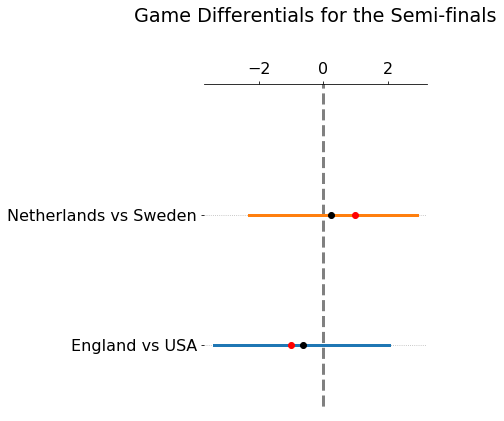

In [55]:
coefficient_plot(df_teamdifferentials_semis['midway'], 
                          df_teamdifferentials_semis['left'], 
                          df_teamdifferentials_semis['right'], 
                          np.array(semis_dict['actual_score_differential']),
                          names=df_teamdifferentials_semis['names'], 
                          title='Game Differentials for the Semi-finals', 
                          fig_size = (4,6))
plt.tight_layout()

<h2> 7. Make your own tournament! <a name="Exercises"></a> </h2>

<center><h2>  </h2></center>